In [16]:
from qutip import *
#QuTiP control modules
import qutip.control.pulseoptim as cpo
import qutip.logging_utils as logging
logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
log_level = logging.INFO

from qutip.control import * 
from qutip.ui.progressbar import TextProgressBar
from qutip.control.grape import plot_grape_control_fields, _overlap


%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import h5py

C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
U_targetsFile = h5py.File("U_targets.hdf5", 'r')
tssos_glob_obj_minFile = h5py.File("tssos_glob_obj_min.hdf5", 'r')
norm_U_target_minus_obtainedFile = h5py.File("norm_U_target_minus_obtained.hdf5", 'r')




#Find a way to do this using rel path to the Results folder 
#rather than copy paste the file to this directory
#Not import rn but do later

U_targets = np.array(U_targetsFile["U_targets"])
tssos_glob_obj_min = np.array(tssos_glob_obj_minFile["tssos_glob_obj_min"])
norm_U_target_minus_obtained = np.array(norm_U_target_minus_obtainedFile["norm_U_target_minus_obtained"])

sample = U_targets.shape[2]



U_target_arr = []

U_final_pulseoptim = []
U_final_cyGRAPE = []

# U_test = np.zeros((3,3,sample), dtype='complex') 


for i in range(sample):
    # Have a better way by just converting to Qobj for each element in the function but will implement later as I have to rewrite a lot of code
    U_target_arr.append(Qobj(U_targets[:,:,i])) #not a good method for memory  
    
    # U_test[:,:,i] = Qobj(U_targets[:,:,i]) #better way but is unfortunatley casting to a complex value instead of a Qobj (dtype = 'object' didnt work either)

# display(U_test[:,:,0])
# display(U_target_arr[0])

#max(tssos_glob_obj_min)

#norm_U_target_minus_obtained

C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
H_drift_matrix = np.array([[0,0,0],
                           [0,0.515916, 0],
                           [0,0,1]])
H_control_matrix = np.array([[0,1/np.sqrt(2), 0],
                             [1/np.sqrt(2),0,0],
                             [0, 1, 0]])

H_drift = Qobj(H_drift_matrix)
H_control = [Qobj(H_control_matrix)] 
 
# Unitary starting point
U_0 = qeye(3)



C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# pulseoptim

In [18]:
#pulse optim extra params (arbitary values)

# Number of time slots
n_ts = 40
# Time allowed for the evolution
evo_time = 1


# Fidelity error target
fid_err_targ = 1e-10
# Maximum iterations for the optisation algorithm
max_iter = 200
# Maximum (elapsed) time allowed in seconds
max_wall_time = 120
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-20

# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = 'RND' 


C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
for i in range(sample):
    result = cpo.optimize_pulse_unitary(H_drift, H_control, U_0, U_target_arr[i], n_ts, evo_time, 
                fid_err_targ=fid_err_targ, min_grad=min_grad, 
                max_iter=max_iter, max_wall_time=max_wall_time, 
                log_level=log_level,
                init_pulse_type=p_type, 
                gen_stats=True)
    print("Final fidelity error {}".format(result.fid_err))
    #print("Final fidelity {}".format(result.fidelity)) #?? this always gives 0.0 even though the fid_err is never 1.0
    # print("Final gradient normal {}".format(result.grad_norm_final))
    print("Terminated due to {}".format(result.termination_reason))
   
    #Here all terminate due to convergence however if it terminates due to a different reason may cause a problem
    U_final_pulseoptim.append(result.evo_full_final)
    print(i)
    

#display(U_final_pulseoptim)


C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.    

Final fidelity error 0.0030035638584479107
Terminated due to function converged
0


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032621426568645306
Terminated due to function converged
1


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002575634372382063
Terminated due to function converged
2


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003059364353477978
Terminated due to function converged
3


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003726692519596453
Terminated due to function converged
4


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034276870979549345
Terminated due to function converged
5


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034136574514994633
Terminated due to function converged
6


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002885324663422728
Terminated due to function converged
7


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033154528004196715
Terminated due to function converged
8


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.001938726182142414
Terminated due to function converged
9


INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method
INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:


Final fidelity error 0.0032397139853534984
Terminated due to function converged
10


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034000275333953
Terminated due to function converged
11


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003452744640901839
Terminated due to function converged
12


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033095104895943805
Terminated due to function converged
13


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029499574512200644
Terminated due to function converged
14


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034372814101331084
Terminated due to function converged
15


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.020707500361904385
Terminated due to function converged
16


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0020458533534422063
Terminated due to function converged
17


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0028761939946997384
Terminated due to function converged
18


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033651157603394877
Terminated due to function converged
19


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003352709095320039
Terminated due to function converged
20


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031762257890568524
Terminated due to function converged
21


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031407540052236227
Terminated due to function converged
22


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00203075677969744
Terminated due to function converged
23


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003625568183223127
Terminated due to function converged
24


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003177820849835089
Terminated due to function converged
25


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033874664282659284
Terminated due to function converged
26


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003392293065227814
Terminated due to function converged
27


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.01785914944516176
Terminated due to function converged
28


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0025236375445488735
Terminated due to function converged
29


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003443921842125608
Terminated due to function converged
30


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003172198976943763
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
31


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035190714832740166
Terminated due to function converged
32


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034573957371925035
Terminated due to function converged
33


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003386200375203652
Terminated due to function converged
34


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0021381501827459903
Terminated due to function converged
35


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030997651473003707
Terminated due to function converged
36


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00412410305779598
Terminated due to function converged
37


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003238170872716606
Terminated due to function converged
38


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034787898850566767
Terminated due to function converged
39


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0025212518531757544
Terminated due to function converged
40


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0024511679644013684
Terminated due to function converged
41


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002122635704955078
Terminated due to function converged
42


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030449820130665772
Terminated due to function converged
43


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031037313043498216
Terminated due to function converged
44


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003228466823127274
Terminated due to function converged
45


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0028687887854901284
Terminated due to function converged
46


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003359908746565332
Terminated due to function converged
47


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002868886437356055
Terminated due to function converged
48


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0021517570319176116
Terminated due to function converged
49


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003472635215527986
Terminated due to function converged
50


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034876828682873784
Terminated due to function converged
51


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034978590951727506
Terminated due to function converged
52


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.015437852341948943
Terminated due to function converged
53


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034916168596192954
Terminated due to function converged
54


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002852878777103718
Terminated due to function converged
55


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019605872752539444
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
56


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003594599875707316
Terminated due to function converged
57


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.020518514763153695
Terminated due to function converged
58


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003592803195566985
Terminated due to function converged
59


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002248224214135841
Terminated due to function converged
60


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031168646854417004
Terminated due to function converged
61


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034240282054611715
Terminated due to function converged
62


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029180757612494723
Terminated due to function converged
63


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003465330708353198
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
64


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003287467312680703
Terminated due to function converged
65


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029907526732492196
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
66


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003452862367435028
Terminated due to function converged
67


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002968517583947672
Terminated due to function converged
68


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033749651537410275
Terminated due to function converged
69


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002991410602920741
Terminated due to function converged
70


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002679138197579589
Terminated due to function converged
71


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034677762017591984
Terminated due to function converged
72


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003287903012776705
Terminated due to function converged
73


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00200128018665946
Terminated due to function converged
74


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002766635694748887
Terminated due to function converged
75


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0028895760816955995
Terminated due to function converged
76


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0037112290841778695
Terminated due to function converged
77


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003241154523305978
Terminated due to function converged
78


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0025928965191057696
Terminated due to function converged
79


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002945116657516622
Terminated due to function converged
80


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030771487763893157
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
81


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003249196087079631
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
82


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002011009274372033
Terminated due to function converged
83


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033864576540169056
Terminated due to function converged
84


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033269990915140157
Terminated due to function converged
85


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003428366056502763
Terminated due to function converged
86


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003105567367121642
Terminated due to function converged
87


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034269941883440236
Terminated due to function converged
88


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003214948625646974
Terminated due to function converged
89


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0025900902019051486
Terminated due to function converged
90


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0049323021655718335
Terminated due to function converged
91


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036048971731393875
Terminated due to function converged
92


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002569495806482247
Terminated due to function converged
93


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0021219690861423723
Terminated due to function converged
94


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003823633507227475
Terminated due to function converged
95


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002019704669452227
Terminated due to function converged
96


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003654357313119583
Terminated due to function converged
97


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002787994316118203
Terminated due to function converged
98


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032032395053815943
Terminated due to function converged
99


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019953082284598356
Terminated due to function converged
100


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019969273352995476
Terminated due to function converged
101


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.010893989711531105
Terminated due to function converged
102


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033679212888656496
Terminated due to function converged
103


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034011998544540845
Terminated due to function converged
104


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003428643599549752
Terminated due to function converged
105


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003963130850266894
Terminated due to function converged
106


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034969710053065484
Terminated due to function converged
107


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.010669775526738423
Terminated due to function converged
108


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030134805513644114
Terminated due to function converged
109


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031060150716911705
Terminated due to function converged
110


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003566116094228744
Terminated due to function converged
111


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003126819862960817
Terminated due to function converged
112


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029872545925981875
Terminated due to function converged
113


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030708961205766494
Terminated due to function converged
114


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.001930773539728703
Terminated due to function converged
115


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032793376641720995
Terminated due to function converged
116


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003417338320914398
Terminated due to function converged
117


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0026938009604408064
Terminated due to function converged
118


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003059315381526484
Terminated due to function converged
119


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032337075554550454
Terminated due to function converged
120


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003585836453784741
Terminated due to function converged
121


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003341183662492253
Terminated due to function converged
122


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033503201401045013
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
123


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.001995280326470894
Terminated due to function converged
124


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033215291246051493
Terminated due to function converged
125


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003211582222587439
Terminated due to function converged
126


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032289699502977554
Terminated due to function converged
127


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0045072420754403986
Terminated due to function converged
128


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.004147065893485347
Terminated due to function converged
129


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030498983735576246
Terminated due to function converged
130


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003139764255075228
Terminated due to function converged
131


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00232186205444751
Terminated due to function converged
132


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036201221727942823
Terminated due to function converged
133


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034751290281609393
Terminated due to function converged
134


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032282183828791222
Terminated due to function converged
135


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029065794767123565
Terminated due to function converged
136


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003144360513656075
Terminated due to function converged
137


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002997314421263053
Terminated due to function converged
138


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036730781958036474
Terminated due to function converged
139


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002085323914287951
Terminated due to function converged
140


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00318552646804815
Terminated due to function converged
141


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034808490181469365
Terminated due to function converged
142


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0021123998819874146
Terminated due to function converged
143


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003312335196377081
Terminated due to function converged
144


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003253394223700412
Terminated due to function converged
145


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003434480723418676
Terminated due to function converged
146


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003457713041972621
Terminated due to function converged
147


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0023048638004770083
Terminated due to function converged
148


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033680057937270913
Terminated due to function converged
149


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034553600763277403
Terminated due to function converged
150


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034627417964789853
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
151


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003508796626880639
Terminated due to function converged
152


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031208930338639806
Terminated due to function converged
153


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033609463171616616
Terminated due to function converged
154


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003117253017628663
Terminated due to function converged
155


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003148374377387353
Terminated due to function converged
156


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029186597705307404
Terminated due to function converged
157


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034907959495050767
Terminated due to function converged
158


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0027832092581009382
Terminated due to function converged
159


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035951544398751256
Terminated due to function converged
160


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.001970366477411556
Terminated due to function converged
161


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002837833552245317
Terminated due to function converged
162


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00333896264564415
Terminated due to function converged
163


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002320579747810414
Terminated due to function converged
164


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032643311948908904
Terminated due to function converged
165


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003582275247063671
Terminated due to function converged
166


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003447562266027271
Terminated due to function converged
167


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029688528536016
Terminated due to function converged
168


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002259334063576368
Terminated due to function converged
169


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003595208639878944
Terminated due to function converged
170


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0027436105220252083
Terminated due to function converged
171


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033185015339213253
Terminated due to function converged
172


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002985462797491234
Terminated due to function converged
173


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003124145385256627
Terminated due to function converged
174


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031802091151652556
Terminated due to function converged
175


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003503657032590368
Terminated due to function converged
176


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003468300032088645
Terminated due to function converged
177


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003533935318936088
Terminated due to function converged
178


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034794756463704113
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
179


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002888688516692106
Terminated due to function converged
180


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032528616567487623
Terminated due to function converged
181


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031966303396391282
Terminated due to function converged
182


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036012963548425203
Terminated due to function converged
183


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029365159230821947
Terminated due to function converged
184


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003341999503470916
Terminated due to function converged
185


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0022683399874483534
Terminated due to function converged
186


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030275788627323053
Terminated due to function converged
187


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031344009386152782
Terminated due to function converged
188


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003610120459651589
Terminated due to function converged
189


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034719434839658447
Terminated due to function converged
190


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002872533792600329
Terminated due to function converged
191


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029777455537249864
Terminated due to function converged
192


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003228110682326868
Terminated due to function converged
193


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029472327443816893
Terminated due to function converged
194


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002120648355078969
Terminated due to function converged
195


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0020139391066654744
Terminated due to function converged
196


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003403501795223862
Terminated due to function converged
197


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033822501597463583
Terminated due to function converged
198


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034348494146106967
Terminated due to function converged
199


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0026800330193482713
Terminated due to function converged
200


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034904563759171614
Terminated due to function converged
201


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033186239173871313
Terminated due to function converged
202


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003486062422088043
Terminated due to function converged
203


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003241542798610997
Terminated due to function converged
204


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029230287662839194
Terminated due to function converged
205


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002942221068736095
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
206


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.008498715860402184
Terminated due to function converged
207


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034255771026893145
Terminated due to function converged
208


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030659195651862037
Terminated due to function converged
209


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002078140620399793
Terminated due to function converged
210


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003465610237771366
Terminated due to function converged
211


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00209800673508298
Terminated due to function converged
212


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002587233662209809
Terminated due to function converged
213


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032967501278510225
Terminated due to function converged
214


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002248939284850482
Terminated due to function converged
215


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003242845559392138
Terminated due to function converged
216


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0020159491022111453
Terminated due to function converged
217


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030454623980913365
Terminated due to function converged
218


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032951817144348805
Terminated due to function converged
219


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035169462717459243
Terminated due to function converged
220


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003189946976948299
Terminated due to function converged
221


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019708202375713357
Terminated due to function converged
222


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032015578638429076
Terminated due to function converged
223


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0028020763470160137
Terminated due to function converged
224


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033306528458008078
Terminated due to function converged
225


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0018897309285266228
Terminated due to function converged
226


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030778683294714337
Terminated due to function converged
227


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003348116942696877
Terminated due to function converged
228


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003418931137144088
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
229


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035129915317266835
Terminated due to function converged
230


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029302034243776642
Terminated due to function converged
231


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003431494150693437
Terminated due to function converged
232


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003003893126516277
Terminated due to function converged
233


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034959293051892715
Terminated due to function converged
234


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031362452114208628
Terminated due to function converged
235


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002731691217779164
Terminated due to function converged
236


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003460939191682222
Terminated due to function converged
237


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030548626473048124
Terminated due to function converged
238


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033582625442577507
Terminated due to function converged
239


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029757737205294843
Terminated due to function converged
240


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0022076189405637603
Terminated due to function converged
241


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00300987426218835
Terminated due to function converged
242


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034403493876300484
Terminated due to function converged
243


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0020422353557916217
Terminated due to function converged
244


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003342919536749367
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
245


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003649785546730566
Terminated due to function converged
246


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032931159195102033
Terminated due to function converged
247


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0028699601079485992
Terminated due to function converged
248


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003293437999242421
Terminated due to function converged
249


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030111715529875793
Terminated due to function converged
250


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002977905252005808
Terminated due to function converged
251


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036358745631906997
Terminated due to function converged
252


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0020522433599214907
Terminated due to function converged
253


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034882333070218596
Terminated due to function converged
254


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031352178594585833
Terminated due to function converged
255


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003426040617613979
Terminated due to function converged
256


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003345458457570394
Terminated due to function converged
257


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029686503436799905
Terminated due to function converged
258


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.014516039168050998
Terminated due to function converged
259


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032938674760170095
Terminated due to function converged
260


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0028224233864787562
Terminated due to function converged
261


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002413385576026772
Terminated due to function converged
262


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0037032173276375646
Terminated due to function converged
263


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033577489909093483
Terminated due to function converged
264


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036138537581636987
Terminated due to function converged
265


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.008268255747801323
Terminated due to function converged
266


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003188232097099175
Terminated due to function converged
267


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003570545059888852
Terminated due to function converged
268


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0037190045941030148
Terminated due to function converged
269


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.005574351412967693
Terminated due to function converged
270


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033719704305916753
Terminated due to function converged
271


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003387348672887258
Terminated due to function converged
272


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032833115723911455
Terminated due to function converged
273


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036422456535163406
Terminated due to function converged
274


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003352419697502551
Terminated due to function converged
275


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00296997410156441
Terminated due to function converged
276


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.020696382262862523
Terminated due to function converged
277


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.020532599219552194
Terminated due to function converged
278


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003599027486611117
Terminated due to function converged
279


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002761670121268711
Terminated due to function converged
280


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033615687136862027
Terminated due to function converged
281


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003305650387580239
Terminated due to function converged
282


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035819324552099907
Terminated due to function converged
283


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003323331399863294
Terminated due to function converged
284


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0025369917140956044
Terminated due to function converged
285


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0022424831314390437
Terminated due to function converged
286


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019549044190252385
Terminated due to function converged
287


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003482167505648226
Terminated due to function converged
288


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034628766100955888
Terminated due to function converged
289


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0020228785186839904
Terminated due to function converged
290


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031315988347890844
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
291


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003166365923726655
Terminated due to function converged
292


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0024543234192335728
Terminated due to function converged
293


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033930571469209525
Terminated due to function converged
294


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030325326193757496
Terminated due to function converged
295


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034080323108809374
Terminated due to function converged
296


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003223960972896567
Terminated due to function converged
297


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033664291279851266
Terminated due to function converged
298


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035660975292446384
Terminated due to function converged
299


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003469147334618894
Terminated due to function converged
300


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.005541122174291924
Terminated due to function converged
301


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031897276970626054
Terminated due to function converged
302


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019482612265739885
Terminated due to function converged
303


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032651489143743495
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
304


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003271194222651319
Terminated due to function converged
305


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029372428849779864
Terminated due to function converged
306


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003349169376295591
Terminated due to function converged
307


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033628991484029314
Terminated due to function converged
308


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00221024189876895
Terminated due to function converged
309


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002480378583464393
Terminated due to function converged
310


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002235234544659237
Terminated due to function converged
311


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0028111721420744917
Terminated due to function converged
312


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.001911341473944339
Terminated due to function converged
313


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003133777749751765
Terminated due to function converged
314


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0020347679456411694
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
315


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034876436345360196
Terminated due to function converged
316


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003019788926579725
Terminated due to function converged
317


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0021718045288301457
Terminated due to function converged
318


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0020091117254102953
Terminated due to function converged
319


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035137543779798497
Terminated due to function converged
320


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003098266480526468
Terminated due to function converged
321


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.006464242106889451
Terminated due to function converged
322


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003316685691342691
Terminated due to function converged
323


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.001951578625935979
Terminated due to function converged
324


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00415151828417859
Terminated due to function converged
325


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031327891033672284
Terminated due to function converged
326


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032435204873405565
Terminated due to function converged
327


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035207870090215865
Terminated due to function converged
328


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002054258313655799
Terminated due to function converged
329


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034224511783623734
Terminated due to function converged
330


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003426267977768682
Terminated due to function converged
331


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0025937647699658672
Terminated due to function converged
332


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003635197901170506
Terminated due to function converged
333


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002020350160830464
Terminated due to function converged
334


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003389748031914941
Terminated due to function converged
335


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033424837282556297
Terminated due to function converged
336


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036570862311605667
Terminated due to function converged
337


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003355217763571061
Terminated due to function converged
338


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00250991719465099
Terminated due to function converged
339


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0026440148752503445
Terminated due to function converged
340


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0021691526293821095
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
341


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0026303873000568245
Terminated due to function converged
342


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002607395136503765
Terminated due to function converged
343


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003625625502538199
Terminated due to function converged
344


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029265811403639264
Terminated due to function converged
345


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003297242142319079
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
346


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036245876152559697
Terminated due to function converged
347


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031487928954546662
Terminated due to function converged
348


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034668810315550136
Terminated due to function converged
349


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003521353064914079
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
350


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00398647243108885
Terminated due to function converged
351


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00311491306873668
Terminated due to function converged
352


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034757278911334843
Terminated due to function converged
353


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002824696147398109
Terminated due to function converged
354


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032812714426569967
Terminated due to function converged
355


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030646812590422456
Terminated due to function converged
356


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.01556066068671269
Terminated due to function converged
357


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002391625533832098
Terminated due to function converged
358


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032674732597658407
Terminated due to function converged
359


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003239633388051888
Terminated due to function converged
360


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034205203007402485
Terminated due to function converged
361


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034173364580966092
Terminated due to function converged
362


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003139939896555144
Terminated due to function converged
363


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003311055286323361
Terminated due to function converged
364


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036107659485581367
Terminated due to function converged
365


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003504349498873016
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
366


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00319442137763859
Terminated due to function converged
367


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031790811178739053
Terminated due to function converged
368


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002721500142311095
Terminated due to function converged
369


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003324343771917926
Terminated due to function converged
370


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00200469247545898
Terminated due to function converged
371


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003000674726874375
Terminated due to function converged
372


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003060438229697815
Terminated due to function converged
373


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030041513609648796
Terminated due to function converged
374


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031644157009683704
Terminated due to function converged
375


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003544968592627429
Terminated due to function converged
376


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030999317844327967
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
377


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0039670075796715
Terminated due to function converged
378


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033768859769054416
Terminated due to function converged
379


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032168169053847784
Terminated due to function converged
380


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035272573669135054
Terminated due to function converged
381


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034677039291771683
Terminated due to function converged
382


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003197739077844375
Terminated due to function converged
383


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035371272502572326
Terminated due to function converged
384


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0026970506200415523
Terminated due to function converged
385


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030455663710705627
Terminated due to function converged
386


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033047078298981125
Terminated due to function converged
387


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035397272803046054
Terminated due to function converged
388


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0026556424295084424
Terminated due to function converged
389


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0028111047460684935
Terminated due to function converged
390


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003500079191107286
Terminated due to function converged
391


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00216907773924635
Terminated due to function converged
392


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002242914255245587
Terminated due to function converged
393


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003924807524302021
Terminated due to function converged
394


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034227396935178067
Terminated due to function converged
395


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030845500064548004
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
396


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002302375917601407
Terminated due to function converged
397


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003230121079486281
Terminated due to function converged
398


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0027609208176362365
Terminated due to function converged
399


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002964402654403453
Terminated due to function converged
400


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030106557445096493
Terminated due to function converged
401


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003293755749095517
Terminated due to function converged
402


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003385159289738704
Terminated due to function converged
403


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003225778417216052
Terminated due to function converged
404


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002880345267622042
Terminated due to function converged
405


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036796700764019086
Terminated due to function converged
406


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0024905613877242994
Terminated due to function converged
407


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0021098736149316455
Terminated due to function converged
408


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031183306302804414
Terminated due to function converged
409


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036219020444048233
Terminated due to function converged
410


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.008902568544338019
Terminated due to function converged
411


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002709402024349994
Terminated due to function converged
412


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002059558267071715
Terminated due to function converged
413


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033160000874979945
Terminated due to function converged
414


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.004796141318227143
Terminated due to function converged
415


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0020739375120648607
Terminated due to function converged
416


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003501354903031606
Terminated due to function converged
417


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035432310487172325
Terminated due to function converged
418


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033861039481846156
Terminated due to function converged
419


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035544798344911976
Terminated due to function converged
420


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.004239716271522975
Terminated due to function converged
421


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002968974757134313
Terminated due to function converged
422


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033478536921064395
Terminated due to function converged
423


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0037582950125039094
Terminated due to function converged
424


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003317761763235949
Terminated due to function converged
425


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002908383533988257
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
426


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034407331260445373
Terminated due to function converged
427


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00332079209235725
Terminated due to function converged
428


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003638591021959403
Terminated due to function converged
429


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032090812007272707
Terminated due to function converged
430


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0028144690563254304
Terminated due to function converged
431


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034930045991760084
Terminated due to function converged
432


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00201651126286706
Terminated due to function converged
433


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0022930435445156494
Terminated due to function converged
434


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029735139962665524
Terminated due to function converged
435


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002399445216508811
Terminated due to function converged
436


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029622315206173644
Terminated due to function converged
437


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00295337074717017
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
438


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0026814293205481565
Terminated due to function converged
439


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003401766060982081
Terminated due to function converged
440


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035732694904387907
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
441


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003669854998480826
Terminated due to function converged
442


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032752148540844406
Terminated due to function converged
443


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034632089444223135
Terminated due to function converged
444


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0025737536738956734
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
445


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0020700012896033293
Terminated due to function converged
446


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019740828015213374
Terminated due to function converged
447


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002853018696514331
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
448


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0028141184171790457
Terminated due to function converged
449


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00302162143845619
Terminated due to function converged
450


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002539809711786911
Terminated due to function converged
451


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003062223274908127
Terminated due to function converged
452


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032238451223789433
Terminated due to function converged
453


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002887259026203015
Terminated due to function converged
454


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034832909385358324
Terminated due to function converged
455


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003297190968436947
Terminated due to function converged
456


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.006624568683878285
Terminated due to function converged
457


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00340208606812209
Terminated due to function converged
458


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034083601787173734
Terminated due to function converged
459


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003110393102802589
Terminated due to function converged
460


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035558275482966417
Terminated due to function converged
461


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00334410736304136
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
462


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030687052232922785
Terminated due to function converged
463


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003365109368716146
Terminated due to function converged
464


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00210396480592856
Terminated due to function converged
465


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019698357688237023
Terminated due to function converged
466


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003443759896358367
Terminated due to function converged
467


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003410700163470781
Terminated due to function converged
468


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00347330341660701
Terminated due to function converged
469


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035003972362094293
Terminated due to function converged
470


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019214573143772062
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
471


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033563122173915216
Terminated due to function converged
472


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030614420259071906
Terminated due to function converged
473


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032760204312339836
Terminated due to function converged
474


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002084635941736357
Terminated due to function converged
475


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033472497898600073
Terminated due to function converged
476


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003304997324004688
Terminated due to function converged
477


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.007915390990257842
Terminated due to function converged
478


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0027841163457679174
Terminated due to function converged
479


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033923025923581207
Terminated due to function converged
480


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019636379655744163
Terminated due to function converged
481


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003358255068633409
Terminated due to function converged
482


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019909637266186664
Terminated due to function converged
483


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003780881361005628
Terminated due to function converged
484


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029985643838871257
Terminated due to function converged
485


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032979807735008526
Terminated due to function converged
486


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002860393050656329
Terminated due to function converged
487


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.006357037095925944
Terminated due to function converged
488


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002913254716321423
Terminated due to function converged
489


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033445558843385736
Terminated due to function converged
490


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002461062295807559
Terminated due to function converged
491


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00325903739241018
Terminated due to function converged
492


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003259978166724853
Terminated due to function converged
493


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034211785426956354
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
494


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003593496565596377
Terminated due to function converged
495


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0023775204262725946
Terminated due to function converged
496


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002749049414919602
Terminated due to function converged
497


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030249787041087828
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
498


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0076394561749381085
Terminated due to function converged
499


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0026564353215257075
Terminated due to function converged
500


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003019536416003943
Terminated due to function converged
501


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032572454896919734
Terminated due to function converged
502


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030544216610567387
Terminated due to function converged
503


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0027801770657436276
Terminated due to function converged
504


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033125027289416797
Terminated due to function converged
505


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003523498574518502
Terminated due to function converged
506


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019089353477818038
Terminated due to function converged
507


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033203376898113257
Terminated due to function converged
508


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003478162631704196
Terminated due to function converged
509


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003545674943311705
Terminated due to function converged
510


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002918526075456618
Terminated due to function converged
511


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003400956107025177
Terminated due to function converged
512


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031930773395427714
Terminated due to function converged
513


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00361706246283211
Terminated due to function converged
514


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003074086347762406
Terminated due to function converged
515


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003381105248362437
Terminated due to function converged
516


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034301590137455484
Terminated due to function converged
517


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003631132277612803
Terminated due to function converged
518


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030438472295155616
Terminated due to function converged
519


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003359232738546658
Terminated due to function converged
520


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033118488895594878
Terminated due to function converged
521


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003206601406794296
Terminated due to function converged
522


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003501498949659787
Terminated due to function converged
523


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034335166859805755
Terminated due to function converged
524


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00336013920377376
Terminated due to function converged
525


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003692550858493404
Terminated due to function converged
526


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034280153660796175
Terminated due to function converged
527


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034189787223342094
Terminated due to function converged
528


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036729077539990884
Terminated due to function converged
529


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034076421124290546
Terminated due to function converged
530


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034146434934114733
Terminated due to function converged
531


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003878065089329419
Terminated due to function converged
532


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00893879106413964
Terminated due to function converged
533


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035234340542732445
Terminated due to function converged
534


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032920294668375982
Terminated due to function converged
535


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002872773789450056
Terminated due to function converged
536


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0020521653673205575
Terminated due to function converged
537


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003082056159726898
Terminated due to function converged
538


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035495547436528163
Terminated due to function converged
539


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0038068631249167373
Terminated due to function converged
540


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00333093240257587
Terminated due to function converged
541


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034980157574902027
Terminated due to function converged
542


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.009776262151324988
Terminated due to function converged
543


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0021178645307370347
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
544


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002739329485008768
Terminated due to function converged
545


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034588637661419064
Terminated due to function converged
546


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003114425227197959
Terminated due to function converged
547


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031486039325359094
Terminated due to function converged
548


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002731648069802528
Terminated due to function converged
549


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0023879644479656292
Terminated due to function converged
550


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00346826854543536
Terminated due to function converged
551


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003081507235642822
Terminated due to function converged
552


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003049863379329776
Terminated due to function converged
553


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029645004541416498
Terminated due to function converged
554


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0020980410025804863
Terminated due to function converged
555


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.019738769172622517
Terminated due to function converged
556


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032883776834595757
Terminated due to function converged
557


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003582045449686766
Terminated due to function converged
558


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003622844533988201
Terminated due to function converged
559


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032042010445203495
Terminated due to function converged
560


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.009963920997604458
Terminated due to function converged
561


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002112409063854237
Terminated due to function converged
562


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003567446006408459
Terminated due to function converged
563


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002904978385257939
Terminated due to function converged
564


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036864754295571345
Terminated due to function converged
565


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0021149965341783483
Terminated due to function converged
566


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003328477826189502
Terminated due to function converged
567


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003501127350651889
Terminated due to function converged
568


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002925083370109771
Terminated due to function converged
569


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030387580096071787
Terminated due to function converged
570


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032559319589624547
Terminated due to function converged
571


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032913150061354424
Terminated due to function converged
572


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0022277378858216457
Terminated due to function converged
573


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019402022205947667
Terminated due to function converged
574


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032450652426638804
Terminated due to function converged
575


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033252190081507482
Terminated due to function converged
576


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003092199374006621
Terminated due to function converged
577


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003832075695973991
Terminated due to function converged
578


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035577641211907984
Terminated due to function converged
579


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032747007613987966
Terminated due to function converged
580


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035051708969271456
Terminated due to function converged
581


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029967243977384594
Terminated due to function converged
582


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003089833453337132
Terminated due to function converged
583


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032365982532537307
Terminated due to function converged
584


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033069267976311156
Terminated due to function converged
585


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034807178921066884
Terminated due to function converged
586


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034444834460582996
Terminated due to function converged
587


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0028993068258451604
Terminated due to function converged
588


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030968257868166926
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
589


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031909803542579107
Terminated due to function converged
590


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033725910054259733
Terminated due to function converged
591


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002806341010996416
Terminated due to function converged
592


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035084799322763205
Terminated due to function converged
593


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035556865798171966
Terminated due to function converged
594


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032922058713462654
Terminated due to function converged
595


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030185434913473363
Terminated due to function converged
596


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0026655578253724777
Terminated due to function converged
597


INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method
INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:


Final fidelity error 0.0033415843090044417
Terminated due to function converged
598


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003412135329453392
Terminated due to function converged
599


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029307917799723526
Terminated due to function converged
600


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030926064802966335
Terminated due to function converged
601


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00382540667155018
Terminated due to function converged
602


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030853802685193443
Terminated due to function converged
603


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031817605860037235
Terminated due to function converged
604


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002104049042978229
Terminated due to function converged
605


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003185999321882793
Terminated due to function converged
606


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0024981946888885664
Terminated due to function converged
607


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032222357094497944
Terminated due to function converged
608


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003392399837268689
Terminated due to function converged
609


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031787437129117135
Terminated due to function converged
610


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032986198265626543
Terminated due to function converged
611


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034944367253731956
Terminated due to function converged
612


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0020172818891895927
Terminated due to function converged
613


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003393151374469161
Terminated due to function converged
614


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002988815901345143
Terminated due to function converged
615


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031484999283712956
Terminated due to function converged
616


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032355606058961373
Terminated due to function converged
617


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034136142424450178
Terminated due to function converged
618


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0018651351998387744
Terminated due to function converged
619


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034267604301617682
Terminated due to function converged
620


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003372237854596505
Terminated due to function converged
621


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031846348895149257
Terminated due to function converged
622


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036330129759097884
Terminated due to function converged
623


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003687602279394575
Terminated due to function converged
624


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.006803004087272302
Terminated due to function converged
625


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031345586507467438
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
626


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003556913096067982
Terminated due to function converged
627


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035588994581506883
Terminated due to function converged
628


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031137405864831713
Terminated due to function converged
629


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032205244359746477
Terminated due to function converged
630


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.008434443173251815
Terminated due to function converged
631


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002503850297849497
Terminated due to function converged
632


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003532003345535273
Terminated due to function converged
633


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.013253529767402461
Terminated due to function converged
634


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003130658608247794
Terminated due to function converged
635


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003286016961363325
Terminated due to function converged
636


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003168554043868621
Terminated due to function converged
637


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003225790436193421
Terminated due to function converged
638


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0028556019611104544
Terminated due to function converged
639


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032774295111955842
Terminated due to function converged
640


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030061376822485553
Terminated due to function converged
641


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003434868747170361
Terminated due to function converged
642


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002836506592131527
Terminated due to function converged
643


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003107703043012
Terminated due to function converged
644


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034383487166406157
Terminated due to function converged
645


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029680091584611823
Terminated due to function converged
646


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002589886699683186
Terminated due to function converged
647


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030873598303350347
Terminated due to function converged
648


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0026706421543384318
Terminated due to function converged
649


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003249573088448532
Terminated due to function converged
650


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003458261748496616
Terminated due to function converged
651


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030782797421354813
Terminated due to function converged
652


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.005790387650837836
Terminated due to function converged
653


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0021854590097261095
Terminated due to function converged
654


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003134803807315123
Terminated due to function converged
655


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0025747665234089334
Terminated due to function converged
656


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003153683932227258
Terminated due to function converged
657


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003392856999940297
Terminated due to function converged
658


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003513860719844164
Terminated due to function converged
659


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036675531521310756
Terminated due to function converged
660


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003272891930281019
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
661


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003260952285052965
Terminated due to function converged
662


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031216882241111854
Terminated due to function converged
663


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00206476679501566
Terminated due to function converged
664


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035981015310636577
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
665


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0020589730145059715
Terminated due to function converged
666


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029473198538642054
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
667


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002145661741954963
Terminated due to function converged
668


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034278170959928245
Terminated due to function converged
669


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003368807233645632
Terminated due to function converged
670


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0020703160249618824
Terminated due to function converged
671


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0027676741835283014
Terminated due to function converged
672


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00326970979038943
Terminated due to function converged
673


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.005600218360648723
Terminated due to function converged
674


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036296986751152005
Terminated due to function converged
675


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033605451181458745
Terminated due to function converged
676


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003369820524790401
Terminated due to function converged
677


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029272165759631763
Terminated due to function converged
678


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036396963261499105
Terminated due to function converged
679


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003100178822408428
Terminated due to function converged
680


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002410503043323242
Terminated due to function converged
681


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031456932744364785
Terminated due to function converged
682


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0024777917619002165
Terminated due to function converged
683


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0022124473738383
Terminated due to function converged
684


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030504336342804805
Terminated due to function converged
685


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0027869739640794533
Terminated due to function converged
686


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.004820807611233713
Terminated due to function converged
687


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030980272411805787
Terminated due to function converged
688


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003646445756145922
Terminated due to function converged
689


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.008301643813820259
Terminated due to function converged
690


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034513008041434645
Terminated due to function converged
691


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002497874800741595
Terminated due to function converged
692


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002599341276485867
Terminated due to function converged
693


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035425715944320535
Terminated due to function converged
694


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034420960552851154
Terminated due to function converged
695


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002404501330329989
Terminated due to Iteration or fidelity function call limit reached
696


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003366553942314887
Terminated due to function converged
697


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.016934207589651917
Terminated due to function converged
698


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.001941889291831922
Terminated due to function converged
699


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003564071776362865
Terminated due to function converged
700


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031335131099398117
Terminated due to function converged
701


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0020912130959581665
Terminated due to function converged
702


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003383567276333599
Terminated due to function converged
703


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033353450009300234
Terminated due to function converged
704


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003105474609906844
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
705


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.004436848023840145
Terminated due to function converged
706


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032191075559327986
Terminated due to function converged
707


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0027204299020511247
Terminated due to function converged
708


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019069753063671868
Terminated due to function converged
709


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032875501801375995
Terminated due to function converged
710


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031474591933975393
Terminated due to function converged
711


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0024269192509042137
Terminated due to function converged
712


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003576993233014303
Terminated due to function converged
713


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032648232054796056
Terminated due to function converged
714


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019294313349799141
Terminated due to function converged
715


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003445909070289521
Terminated due to function converged
716


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003310620564131339
Terminated due to function converged
717


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003135544976800242
Terminated due to function converged
718


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036022835282251142
Terminated due to function converged
719


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003267079053713262
Terminated due to function converged
720


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030811186174983796
Terminated due to function converged
721


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032340953811407225
Terminated due to function converged
722


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002163112377100096
Terminated due to function converged
723


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034331964047351615
Terminated due to function converged
724


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0022103404589954856
Terminated due to function converged
725


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032574486024857796
Terminated due to function converged
726


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033874757945568934
Terminated due to function converged
727


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033897976622889736
Terminated due to function converged
728


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00341233872953306
Terminated due to function converged
729


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003167050301140839
Terminated due to function converged
730


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003291363631973354
Terminated due to function converged
731


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031728860402244763
Terminated due to function converged
732


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034068724141521622
Terminated due to function converged
733


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035970044563956582
Terminated due to function converged
734


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.004346598056210738
Terminated due to function converged
735


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0028275886818266427
Terminated due to function converged
736


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002449169785269101
Terminated due to function converged
737


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00328216855417629
Terminated due to function converged
738


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002530609854338395
Terminated due to function converged
739


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029176298769052478
Terminated due to function converged
740


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003543262609059128
Terminated due to function converged
741


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0028408058897746447
Terminated due to function converged
742


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0026142000853803804
Terminated due to function converged
743


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002818474466335874
Terminated due to function converged
744


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002956099947113211
Terminated due to function converged
745


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.01656833676878844
Terminated due to function converged
746


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030158931761246066
Terminated due to function converged
747


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035946218953273323
Terminated due to function converged
748


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032443604627448996
Terminated due to function converged
749


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002230748441662267
Terminated due to function converged
750


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002402456826785415
Terminated due to function converged
751


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0068818819417677535
Terminated due to function converged
752


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0067612116104111
Terminated due to function converged
753


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034880015932770014
Terminated due to function converged
754


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.020699580234127324
Terminated due to function converged
755


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003424037075558828
Terminated due to function converged
756


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002721046465292809
Terminated due to function converged
757


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035011532382497323
Terminated due to function converged
758


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003266240757725747
Terminated due to function converged
759


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003637374319618525
Terminated due to function converged
760


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002105379945802288
Terminated due to function converged
761


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036576858756114383
Terminated due to function converged
762


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035469266365673047
Terminated due to function converged
763


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033221527021812802
Terminated due to function converged
764


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00290686280699326
Terminated due to function converged
765


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003628906986181346
Terminated due to function converged
766


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002948035720157227
Terminated due to function converged
767


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031544422696661023
Terminated due to function converged
768


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003385681162069387
Terminated due to function converged
769


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002699229079858423
Terminated due to function converged
770


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0020778496989537487
Terminated due to function converged
771


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032085477103932503
Terminated due to function converged
772


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00284492682359061
Terminated due to function converged
773


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003396799851487331
Terminated due to function converged
774


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.020669428384720856
Terminated due to function converged
775


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0038805881895193073
Terminated due to function converged
776


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003588346701304812
Terminated due to function converged
777


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003291559558612711
Terminated due to function converged
778


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003264789032339399
Terminated due to function converged
779


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.001984083285031857
Terminated due to function converged
780


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003560693605378362
Terminated due to function converged
781


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003354581826518932
Terminated due to function converged
782


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0021652108510382684
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
783


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002045035305905052
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
784


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.005881870300155634
Terminated due to function converged
785


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0021914673094360904
Terminated due to function converged
786


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034260981438978266
Terminated due to function converged
787


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033508065043430513
Terminated due to function converged
788


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003160272352980553
Terminated due to function converged
789


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002969722076732295
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
790


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034546352318371998
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
791


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031212914233645916
Terminated due to function converged
792


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00304276092964173
Terminated due to function converged
793


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0026977247122675907
Terminated due to function converged
794


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.02060388305740779
Terminated due to function converged
795


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034588813832080456
Terminated due to function converged
796


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036481913381656295
Terminated due to function converged
797


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00283450289019338
Terminated due to function converged
798


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003047067158946204
Terminated due to function converged
799


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031282637681062653
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
800


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003142850662902874
Terminated due to function converged
801


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031385710138945866
Terminated due to function converged
802


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003462526893697415
Terminated due to function converged
803


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019250359006236506
Terminated due to function converged
804


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029056642541954725
Terminated due to function converged
805


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003327927472863035
Terminated due to function converged
806


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003162271249820159
Terminated due to function converged
807


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.020725620293214786
Terminated due to function converged
808


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003208833359535812
Terminated due to function converged
809


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0018834912813843196
Terminated due to function converged
810


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003417196489408192
Terminated due to function converged
811


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003611527763040745
Terminated due to function converged
812


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035273243577517155
Terminated due to function converged
813


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036439521374076467
Terminated due to function converged
814


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003044375017128176
Terminated due to function converged
815


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003038163192807475
Terminated due to function converged
816


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002034117495852583
Terminated due to function converged
817


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002215301998464647
Terminated due to function converged
818


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003095301873810019
Terminated due to function converged
819


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033290870139996986
Terminated due to function converged
820


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.017004937448987345
Terminated due to function converged
821


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003023902314508664
Terminated due to function converged
822


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.005587947328494214
Terminated due to function converged
823


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003380925334996898
Terminated due to function converged
824


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003287767359089311
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
825


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002716931276995016
Terminated due to function converged
826


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019286729177854234
Terminated due to function converged
827


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019314866828489263
Terminated due to function converged
828


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032505398606786917
Terminated due to function converged
829


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003211038918673803
Terminated due to function converged
830


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00340990997106827
Terminated due to function converged
831


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003579855141416566
Terminated due to function converged
832


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002750945545368033
Terminated due to function converged
833


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032292453213357275
Terminated due to function converged
834


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003384133697635794
Terminated due to function converged
835


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032446010033887474
Terminated due to function converged
836


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033584554013990076
Terminated due to function converged
837


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003500299192585765
Terminated due to function converged
838


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00965306378836539
Terminated due to function converged
839


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0020716073893136677
Terminated due to function converged
840


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002882333440998308
Terminated due to function converged
841


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0018991190923645096
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
842


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019238348975073594
Terminated due to function converged
843


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029830462026556592
Terminated due to function converged
844


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033973715139140603
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
845


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00255202180085623
Terminated due to function converged
846


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003024205620685727
Terminated due to function converged
847


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033720683912603633
Terminated due to function converged
848


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002800536081034366
Terminated due to function converged
849


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029785434738703875
Terminated due to function converged
850


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003519816332714587
Terminated due to function converged
851


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002926730674108202
Terminated due to function converged
852


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0026675683242854964
Terminated due to function converged
853


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002870661436824018
Terminated due to function converged
854


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035399349252155377
Terminated due to function converged
855


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0022260749160665227
Terminated due to function converged
856


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032377736485569297
Terminated due to function converged
857


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003621914308489238
Terminated due to function converged
858


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003521867393852074
Terminated due to function converged
859


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00202600169223921
Terminated due to function converged
860


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019594465220097446
Terminated due to function converged
861


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0022780878923271963
Terminated due to function converged
862


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003395100487776803
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
863


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003141155603866075
Terminated due to function converged
864


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0027024272691420492
Terminated due to function converged
865


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031458584400244627
Terminated due to function converged
866


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002982203057252608
Terminated due to function converged
867


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003422719755035053
Terminated due to function converged
868


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0028449085411645925
Terminated due to function converged
869


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033162705629532496
Terminated due to function converged
870


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003172379598463615
Terminated due to function converged
871


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032243812765793134
Terminated due to function converged
872


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003382513528675024
Terminated due to function converged
873


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035990536515744243
Terminated due to function converged
874


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034808270387954865
Terminated due to function converged
875


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003182232364745907
Terminated due to function converged
876


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031702837469366196
Terminated due to function converged
877


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030631832408886117
Terminated due to function converged
878


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002130716185703152
Terminated due to function converged
879


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.004063687021279905
Terminated due to function converged
880


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.019011508056118065
Terminated due to function converged
881


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035283325468039584
Terminated due to function converged
882


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036049922988945493
Terminated due to function converged
883


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003101076930948299
Terminated due to function converged
884


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032196530137398316
Terminated due to function converged
885


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032482472601322865
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
886


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0026185303544091765
Terminated due to function converged
887


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029537187193872105
Terminated due to function converged
888


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031358513335917326
Terminated due to function converged
889


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0024686533656480547
Terminated due to function converged
890


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033163096451082064
Terminated due to function converged
891


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032624838446077
Terminated due to function converged
892


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.009307150351056892
Terminated due to function converged
893


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.020697316340265615
Terminated due to function converged
894


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003453160100795216
Terminated due to function converged
895


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0023413345740128655
Terminated due to function converged
896


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033780826803671005
Terminated due to function converged
897


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003197853048677146
Terminated due to function converged
898


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0026364380484455996
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
899


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002998763634786572
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
900


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0021012965633372405
Terminated due to function converged
901


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.004909147926493884
Terminated due to function converged
902


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029736156309552175
Terminated due to function converged
903


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002238736650453821
Terminated due to function converged
904


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003651245861731822
Terminated due to function converged
905


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003241804042810159
Terminated due to function converged
906


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019317336921851336
Terminated due to function converged
907


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030546850444218565
Terminated due to function converged
908


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019493119905095169
Terminated due to function converged
909


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033082243127026123
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
910


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032744072036893224
Terminated due to function converged
911


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003472382285126363
Terminated due to function converged
912


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0023942363021377533
Terminated due to function converged
913


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031188652613337586
Terminated due to function converged
914


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019785601402697583
Terminated due to function converged
915


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031051908965794572
Terminated due to function converged
916


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030182176835491514
Terminated due to function converged
917


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030671731127442925
Terminated due to function converged
918


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034999943419515844
Terminated due to function converged
919


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.02048241583793564
Terminated due to function converged
920


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0023835695338908502
Terminated due to function converged
921


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033828647408502555
Terminated due to function converged
922


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030736951440352156
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
923


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003300634839567329
Terminated due to function converged
924


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.009442007268428476
Terminated due to function converged
925


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003314537407971385
Terminated due to function converged
926


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003155726795581737
Terminated due to function converged
927


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003669922916287649
Terminated due to function converged
928


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00826430031170755
Terminated due to function converged
929


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00326915835594499
Terminated due to function converged
930


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002639276755436515
Terminated due to function converged
931


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0020290554465643984
Terminated due to function converged
932


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0022055031437947514
Terminated due to function converged
933


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035037277883734896
Terminated due to function converged
934


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0025705607758947924
Terminated due to function converged
935


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002820483480846403
Terminated due to function converged
936


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003205962150457431
Terminated due to function converged
937


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003729834257663489
Terminated due to function converged
938


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003120250626009513
Terminated due to function converged
939


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030375378843181533
Terminated due to function converged
940


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003092233671231015
Terminated due to function converged
941


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034265530686576895
Terminated due to function converged
942


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031919382489600245
Terminated due to function converged
943


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034123579805187543
Terminated due to function converged
944


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002905297371666671
Terminated due to function converged
945


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031900715124876244
Terminated due to function converged
946


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035732880146981394
Terminated due to function converged
947


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003480396534395913
Terminated due to function converged
948


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002979357735595878
Terminated due to function converged
949


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003416615775319376
Terminated due to function converged
950


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031909204510705003
Terminated due to function converged
951


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002778568695961048
Terminated due to function converged
952


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00279357470964392
Terminated due to function converged
953


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034289622460133007
Terminated due to function converged
954


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003389630667070098
Terminated due to function converged
955


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0020133666887702795
Terminated due to function converged
956


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032450443584985944
Terminated due to function converged
957


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002879958747450173
Terminated due to function converged
958


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0020027619697466914
Terminated due to function converged
959


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029466982321717516
Terminated due to function converged
960


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003429670476340463
Terminated due to function converged
961


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003278101090916752
Terminated due to function converged
962


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030888050785590204
Terminated due to function converged
963


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0036569692145762556
Terminated due to function converged
964


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029268002196178866
Terminated due to function converged
965


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033386214361698086
Terminated due to function converged
966


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00990698140939228
Terminated due to function converged
967


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0027329110185596583
Terminated due to function converged
968


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029551949846984282
Terminated due to function converged
969


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032559724595472295
Terminated due to function converged
970


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003177380885729164
Terminated due to function converged
971


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002975548290231944
Terminated due to function converged
972


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0033283934972231366
Terminated due to function converged
973


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003067569398730541
Terminated due to function converged
974


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003437762380088083
Terminated due to function converged
975


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0026850989696164396
Terminated due to function converged
976


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0026213297254132906
Terminated due to function converged
977


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034084255779746053
Terminated due to function converged
978


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003370451464129842
Terminated due to function converged
979


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0034774716192539357
Terminated due to function converged
980


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032120033480577126
Terminated due to function converged
981


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002137714652236
Terminated due to function converged
982


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035160007817540695
Terminated due to function converged
983


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003324795687147941
Terminated due to function converged
984


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031873888139318796
Terminated due to function converged
985


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0029993569203825565
Terminated due to function converged
986


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.003261630672444338
Terminated due to function converged
987


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.002810963668029798
Terminated due to function converged
988


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0028644770742402015
Terminated due to function converged
989


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.00314685871769671
Terminated due to function converged
990


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0018591980272962827
Terminated due to function converged
991


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0021259909865827264
Terminated due to function converged
992


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030871062745191358
Terminated due to b'ABNORMAL_TERMINATION_IN_LNSRCH'
993


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0032874980531168996
Terminated due to function converged
994


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0019653052037718055
Terminated due to function converged
995


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0031550863129764517
Terminated due to function converged
996


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0035019488069223392
Terminated due to function converged
997


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.       0.       0.      ]
 [0.       0.515916 0.      ]
 [0.       0.       1.      ]]
Control 1 Hamiltonian:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.        ]
 [0.         1.         0.        ]]
Initial state / operator:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =

Final fidelity error 0.0030363107845655657
Terminated due to function converged
998
Final fidelity error 0.0019400327628712466
Terminated due to function converged
999


In [20]:
# cy_grape params
times = np.linspace(0,evo_time,n_ts)
n_iterations = 100



C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for i in range(sample):
    print(i)
    result = cy_grape_unitary(U_target_arr[i], H_drift, H_control, n_iterations, times, eps=2*np.pi/times[-1], phase_sensitive=False
                           ,progress_bar=TextProgressBar())
    U_final_cyGRAPE.append(result.U_f)
#display(U_final_cyGRAPE)

0


C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


10.0%. Run time:   2.72s. Est. time left: 00:00:00:24
20.0%. Run time:   5.07s. Est. time left: 00:00:00:20
30.0%. Run time:   7.39s. Est. time left: 00:00:00:17
40.0%. Run time:   9.63s. Est. time left: 00:00:00:14
50.0%. Run time:  11.91s. Est. time left: 00:00:00:11
60.0%. Run time:  13.89s. Est. time left: 00:00:00:09
70.0%. Run time:  15.92s. Est. time left: 00:00:00:06
80.0%. Run time:  17.89s. Est. time left: 00:00:00:04
90.0%. Run time:  19.92s. Est. time left: 00:00:00:02
Total run time:  21.63s
1
10.0%. Run time:   1.74s. Est. time left: 00:00:00:15
20.0%. Run time:   3.91s. Est. time left: 00:00:00:15
30.0%. Run time:   5.59s. Est. time left: 00:00:00:13
40.0%. Run time:   7.08s. Est. time left: 00:00:00:10
50.0%. Run time:   8.67s. Est. time left: 00:00:00:08
60.0%. Run time:   9.99s. Est. time left: 00:00:00:06
70.0%. Run time:  11.05s. Est. time left: 00:00:00:04
80.0%. Run time:  12.10s. Est. time left: 00:00:00:03
90.0%. Run time:  13.14s. Est. time left: 00:00:00:01
To

# Plotting Fidelity error (trace norm)

In [87]:
#calculating fidelity

pulseoptim_fidelity = []
cy_grape_fidelity = []


for i in range(sample):
    print(i)
    pulseoptim_fidelity.append(abs(_overlap(U_target_arr[i], U_final_pulseoptim[i])))
    cy_grape_fidelity.append(abs(_overlap(U_target_arr[i], U_final_cyGRAPE[i])))
    
# display(pulseoptim_fidelity)
# display(cy_grape_fidelity)



pulseoptim_fid_error = 1 - np.array(pulseoptim_fidelity) # would be better to directly get the error fidelity by doing result.fid_err in the loop as it is more accurate #but is pretty much the same
cy_grape_fid_error = 1 - np.array(cy_grape_fidelity)


display(pulseoptim_fid_error)






C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

array([0.002684  , 0.02073278, 0.00296159, 0.00250552, 0.00349554,
       0.02070677, 0.00269375, 0.00323528, 0.00320362, 0.00231665,
       0.0207164 , 0.00269261, 0.00271329, 0.0032482 , 0.00266422,
       0.00771041, 0.02072931, 0.00322046, 0.00237745, 0.00269862,
       0.00258764, 0.02070781, 0.00266537, 0.02071572, 0.00315294,
       0.00308213, 0.00248599, 0.00311956, 0.00309211, 0.00269007,
       0.00328296, 0.00299056, 0.00263782, 0.00904643, 0.00249054,
       0.02069785, 0.00740933, 0.00239908, 0.02069283, 0.00269034,
       0.00265427, 0.00262219, 0.00275373, 0.00268638, 0.00316436,
       0.02064321, 0.00269821, 0.00268629, 0.00320791, 0.02071476,
       0.00309314, 0.00322557, 0.02070023, 0.02072471, 0.00304006,
       0.00263659, 0.00259982, 0.00331481, 0.02061348, 0.0026418 ,
       0.00312385, 0.00309653, 0.0027056 , 0.00750545, 0.00268279,
       0.0032343 , 0.00313104, 0.00228377, 0.02073906, 0.00254338,
       0.00305725, 0.00264724, 0.00326455, 0.00274718, 0.00269

## Plot for pulseoptim method


C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


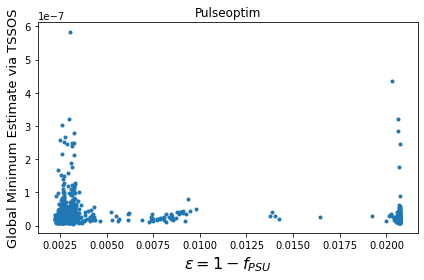

In [81]:
plt.figure()
plt.title('Pulseoptim')
plt.xlabel(r'$\epsilon = 1 - f_{PSU}$', fontsize = 16) 
plt.ylabel('Global Minimum Estimate via TSSOS', fontsize = 13)
plt.plot(pulseoptim_fid_error, tssos_glob_obj_min, '.')
plt.tight_layout()

## Plot for cy_grape method

C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


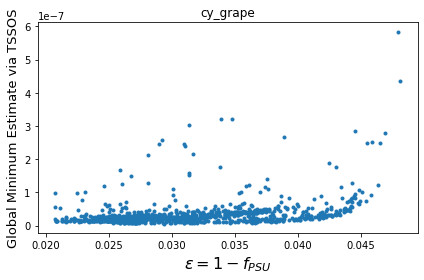

In [84]:
plt.figure()
plt.title('cy_grape')
plt.xlabel(r'$\epsilon = 1 - f_{PSU}$', fontsize = 16) 
plt.ylabel('Global Minimum Estimate via TSSOS', fontsize = 13)
plt.plot(cy_grape_fid_error, tssos_glob_obj_min, '.')
plt.tight_layout()

C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


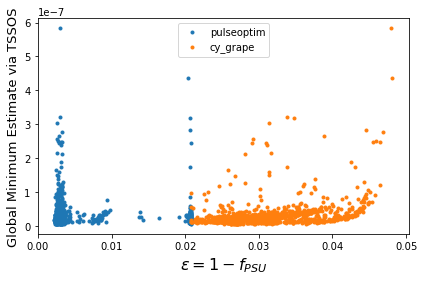

In [85]:
plt.figure()
#plt.title('')
plt.xlabel(r'$\epsilon = 1 - f_{PSU}$', fontsize = 16) 
plt.ylabel('Global Minimum Estimate via TSSOS', fontsize = 13)
plt.plot(pulseoptim_fid_error, tssos_glob_obj_min, '.', label='pulseoptim')
plt.plot(cy_grape_fid_error, tssos_glob_obj_min, '.', label='cy_grape')
plt.legend()
plt.tight_layout()

# Plotting Fidelity error  (Frobenius norm)

In [ ]:
from numpy import linalg as LA

In [ ]:
pulseoptim_fro_norm_squared =  np.zeros(sample)
cy_grape_fro_norm_squared =  np.zeros(sample)
for i in range(sample):
    pulseoptim_fro_norm_squared[i] = LA.norm(U_final_pulseoptim[i] - U_target_arr[i])**2
    cy_grape_fro_norm_squared[i] = LA.norm(U_final_cyGRAPE[i] - U_target_arr[i] )**2

# display(pulseoptim_fro_norm_squared)
# display(cy_grape_fro_norm_squared)



## pulseoptim plot

C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


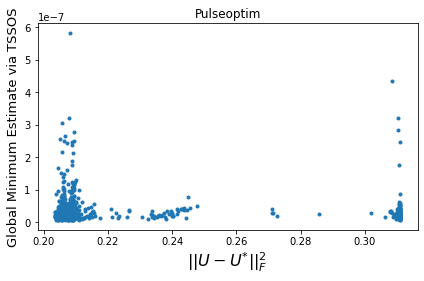

In [86]:
plt.figure()
# plt.rc('text', usetex=False)
plt.title('Pulseoptim')
plt.xlabel(r'$||U - U^{*} ||_{F}^{2}$', fontsize = 16 )
plt.ylabel('Global Minimum Estimate via TSSOS', fontsize=13)
plt.plot(pulseoptim_fro_norm_squared, tssos_glob_obj_min, '.')
plt.tight_layout()

## cy_grape plot

C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


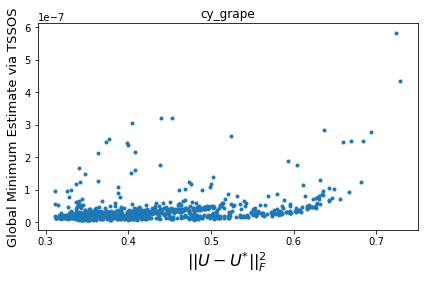

In [83]:
plt.figure()
# plt.rc('text', usetex=False)
plt.title('cy_grape')
plt.xlabel(r'$||U - U^{*} ||_{F}^{2}$', fontsize = 16 )
plt.ylabel('Global Minimum Estimate via TSSOS', fontsize=13)
plt.plot(cy_grape_fro_norm_squared, tssos_glob_obj_min, '.')
plt.tight_layout()

C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


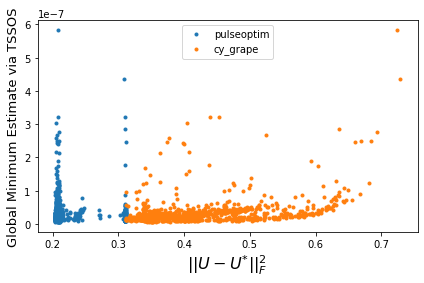

In [82]:
plt.figure()
#plt.title('')
plt.xlabel(r'$||U - U^{*} ||_{F}^{2}$', fontsize = 16 )
plt.ylabel('Global Minimum Estimate via TSSOS', fontsize=13)
plt.plot(pulseoptim_fro_norm_squared, tssos_glob_obj_min, '.', label='pulseoptim')
plt.plot(cy_grape_fro_norm_squared, tssos_glob_obj_min, '.', label='cy_grape')
plt.legend()
plt.tight_layout()

# Plotting Frobenius norm from previous method vs GRAPE method

In [ ]:
plt.figure()
# plt.rc('text', usetex=False)
plt.title('Pulseoptim')
plt.xlabel(r'$||U - U^{*} ||_{F}^{2}$ GRAPE', fontsize = 16 )
plt.ylabel(r'$||U - U^{*} ||_{F}^{2}$ polynomial', fontsize=13)
plt.plot(pulseoptim_fro_norm_squared, norm_U_target_minus_obtained**2, '.')
plt.tight_layout()

In [ ]:
plt.figure()
# plt.rc('text', usetex=False)
plt.title('cy_grape')
plt.xlabel(r'$||U - U^{*} ||_{F}^{2}$ GRAPE', fontsize = 16 )
plt.ylabel(r'$||U - U^{*} ||_{F}^{2}$ polynomial', fontsize=13)
plt.plot(cy_grape_fro_norm_squared, norm_U_target_minus_obtained**2, '.')
plt.tight_layout()

In [ ]:
plt.figure()
# plt.rc('text', usetex=False)
plt.title('Pulseoptim')
plt.xlabel(r'$||U - U^{*} ||_{F}^{2}$ GRAPE', fontsize = 16 )
plt.ylabel(r'$||U - U^{*} ||_{F}^{2}$ polynomial', fontsize=13)
plt.plot(pulseoptim_fro_norm_squared, norm_U_target_minus_obtained**2, '.')
plt.plot(cy_grape_fro_norm_squared, norm_U_target_minus_obtained**2, '.')
plt.tight_layout()

# Writing data to hdf5

In [14]:
with h5py.File('pulseoptim_fro_norm_squared.hdf5', 'w') as hf:
    hf.create_dataset("pulseoptim_fro_norm_squared",  data=pulseoptim_fro_norm_squared)
    
with h5py.File('cy_grape_fro_norm_squared.hdf5', 'w') as hf:
    hf.create_dataset("cy_grape_fro_norm_squared",  data=cy_grape_fro_norm_squared)
    

C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\waqas\Anaconda3\envs\qutip-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.430619236512053